In [1]:
import os
import netCDF4
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches

import datetime

In [2]:
#############################
## Load Data
#############################
#Path
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
filename_sfc_1 = 'Feb2020_Attr_sfc-1950-2020_t2m_24H.nc'

#Load netcdf
ncdf_1 = netCDF4.Dataset(filename_sfc_1)

#Get dimension
lons = ncdf_1.variables['longitude'][:]
lats = ncdf_1.variables['latitude'][:]
times_1 = ncdf_1.variables['time'][:]

#Calculate datetime
dtimes_1 = np.empty(len(times_1), dtype='datetime64[h]')
for i,t in enumerate(times_1):
    dtimes_1[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes_1 = dtimes_1.astype('datetime64')

t2m = ncdf_1.variables['t2m'][:,:,:]-273.15

In [3]:
#Sectors indexs
starting_day = '2019-12-01 00:00:00'
ending_day = '2020-02-29 00:00:00'
AP_lons = [-55, -76]
AP_lats = [-62, -70]
AP_ilats = [np.where(lats == AP_lats[0])[0][0],np.where(lats == AP_lats[1])[0][0]]
AP_ilons = [np.where(lons == AP_lons[0])[0][0],np.where(lons == AP_lons[1])[0][0]]

lons_sec_grid_AP, lats_sec_grid_AP = np.meshgrid(lons[AP_ilons[1]:AP_ilons[0]+1], lats[AP_ilats[0]:AP_ilats[1]+1])
weighting_gridAP = np.sqrt(np.cos(lats_sec_grid_AP*np.pi/180))
weighting_grid_AP = np.sqrt(np.cos(lats_sec_grid_AP*np.pi/180))


In [4]:
#################
# Add Land Sea Mask
#################
#Path
filename_sfc_O = 'ERA5_orograpy-lsm.nc'
ncdf_O = netCDF4.Dataset(filename_sfc_O)
lsm = ncdf_O.variables['lsm'][::2]
lsm = lsm[:,::2,::2]
lsm3d = np.repeat(lsm, np.shape(dtimes_1), axis=0)
t2mm = np.ma.masked_array(t2m, mask=np.logical_not(lsm3d))

lsm_AP = lsm[:,AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]
#TClimm = np.ma.masked_array(TClim, mask=np.logical_not(lsm))
#TClim_APm = np.ma.masked_array(TClim_AP, mask=np.logical_not(lsm_AP))
weighting_grid_APm = np.ma.masked_array(weighting_grid_AP, mask=np.logical_not(lsm_AP))
weighting_gridAPm = np.ma.masked_array(weighting_grid_AP, mask=np.logical_not(lsm_AP))

In [5]:
#############################
#Get Tmean of each day of Fabruary 2020 in the sector and Tmean of februaryof the other years
#############################

########## T2020 ############
#Delimiter lats and lons of the sector to analyze
#Calculate weighting matrix
T_secAP = t2mm[np.argwhere((dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))).flatten(), AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]

T_mean_secAP = np.zeros(np.size(np.argwhere((dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))).flatten()))
for i in range(np.size(np.argwhere((dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))).flatten())):
    T_mean_secAP[i] = np.sum(weighting_gridAPm*(T_secAP[i,:,:]))/np.sum(weighting_gridAPm) #mean weighted by sqrt(cos(lat))

########## TClim ###########
TClim_secAP = t2mm[np.argwhere((dtimes_1 < np.datetime64(starting_day))).flatten(), AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]

TClim_mean_secAP = np.sum(weighting_gridAPm*(TClim_secAP), axis=(1,2))/np.sum(weighting_gridAPm) #mean weighted by sqrt(cos(lat))

TClim_secAP = t2mm[np.argwhere((dtimes_1 < np.datetime64(starting_day))).flatten(), AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]

TClim_mean_secAP = np.zeros(np.size(np.argwhere((dtimes_1 < np.datetime64(starting_day))).flatten()))
for i in range(np.size(np.argwhere((dtimes_1 < np.datetime64(starting_day))).flatten())):
    TClim_mean_secAP[i] = np.sum(weighting_gridAPm*(TClim_secAP[i,:,:]))/np.sum(weighting_gridAPm) #mean weighted by sqrt(cos(lat))

####### Tevolution ########
TClim_secAP = t2mm[:, AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]

Tevo_mean_secAP = np.zeros(np.size(TClim_secAP,0))
for i in range(np.size(TClim_secAP,0)):
    Tevo_mean_secAP[i] = np.sum(weighting_gridAPm*(TClim_secAP[i,:,:]))/np.sum(weighting_gridAPm) #mean weighted by sqrt(cos(lat))

d = {'T_mean_sec': Tevo_mean_secAP}
dfAP = pd.DataFrame(data=d,
              index=dtimes_1)

####### T annual cycle #######


In [6]:
dfAP.groupby([(dfAP.index.month),(dfAP.index.day)])['T_mean_sec'].mean()[:]

1   1    -1.717753
    2    -1.589189
    3    -1.545034
    4    -1.655773
    5    -1.673432
            ...   
12  27   -1.870078
    28   -1.931455
    29   -1.937891
    30   -1.858973
    31   -1.805686
Name: T_mean_sec, Length: 91, dtype: float64

In [7]:
T_mean_secAP-np.mean(TClim_mean_secAP)

array([ 1.00145923,  0.19548343, -0.43847133, -1.04345251, -1.5078962 ,
       -0.27091242,  0.58594679,  0.2858939 , -0.12588073, -0.28871394,
       -0.79057146, -1.02406622, -1.34191085, -1.4649079 , -1.35554029,
       -0.88087798, -0.83957864, -1.18669583, -0.58338596, -0.49995614,
       -0.68203355,  0.17358898,  0.50971578,  0.52763294,  0.43444203,
        0.09129022,  0.94577705,  1.75898265,  1.88845341,  2.20702593,
        2.62230141,  2.30134721,  1.8639168 ,  2.15401797,  2.02292668,
        2.25309547,  1.9548323 ,  2.43330902,  3.66426848,  3.67845248,
        3.30396174,  3.1171218 ,  2.7491029 ,  2.71749895,  2.46077498,
        2.59868269,  1.96322189,  1.41652571,  0.84224461,  0.47324322,
        0.57032894,  0.74991046,  1.02050875,  1.80829232,  1.72270487,
        1.98137717,  1.47269128,  1.81352352,  2.64931441,  2.83750676,
        2.79766952,  2.27975546,  2.20941837,  2.36265917,  2.01141469,
        0.80158077,  0.92760383,  3.66084038,  3.74652897,  4.59

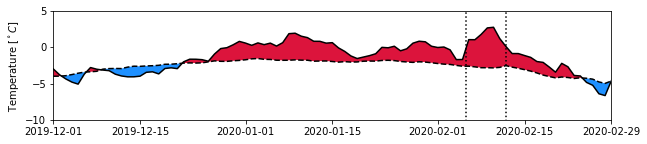

In [8]:
#######################
# Plot sector temperatures
#######################

fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,2))
plt.subplots_adjust(hspace=0)

#Order december before january
T_mean_sec = dfAP.groupby([(dfAP.index.month),(dfAP.index.day)])['T_mean_sec'].mean()
T_mean_sec = np.concatenate([T_mean_sec[T_mean_sec.index[60:]].values,T_mean_sec[T_mean_sec.index[:60]].values])
                      
#Plot Feb Anom AP
ax1.plot(dtimes_1[(dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))], T_mean_sec, 'k--')
ax1.plot(dtimes_1[(dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))],T_mean_secAP-np.mean(TClim_mean_secAP)+T_mean_sec,'k-')
ax1.fill_between(dtimes_1[(dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))], T_mean_sec, T_mean_secAP-np.mean(TClim_mean_secAP)+T_mean_sec, where= T_mean_secAP-np.mean(TClim_mean_secAP) > 0, facecolor='Crimson', interpolate=True)
ax1.fill_between(dtimes_1[(dtimes_1 >= np.datetime64(starting_day)) & (dtimes_1 <= np.datetime64(ending_day))], T_mean_sec, T_mean_secAP-np.mean(TClim_mean_secAP)+T_mean_sec, where= T_mean_secAP-np.mean(TClim_mean_secAP) <= 0, facecolor='DodgerBlue', interpolate=True)

ax1.set_xlim([datetime.datetime(2019, 12, 1, 0),datetime.datetime(2020, 2, 28, 0)])
ax1.set_ylim([-10,5])

#ax1.plot([dtimes_2[dtimes_2 == np.datetime64(starting_day)],dtimes_2[dtimes_2 == np.datetime64(ending_day)]], [4,4], 'k--')
ax1.plot([datetime.datetime(2020, 2, 5, 12),datetime.datetime(2020, 2, 5, 12)], [-20,20], 'k:')
ax1.plot([datetime.datetime(2020, 2, 12, 0),datetime.datetime(2020, 2, 12, 0)], [-20,20], 'k:')

ax1.set_xticks([datetime.date(2019, 12, 1),datetime.date(2019, 12, 15),datetime.date(2020, 1, 1),datetime.date(2020, 1, 15),datetime.date(2020, 2, 1),datetime.date(2020, 2, 15),datetime.date(2020, 2, 29)])
ax1.set_ylabel('Temperature [$^\circ C$]')

plt.savefig('ERA5_Tanom_JanFeb2020.png')

In [9]:
#Mean sector AP temperature during the 6-11 Feb 2020
np.mean([3.66084038,  3.74652897,  4.59353517,  5.49373482,  5.60219549,  3.98028599])

4.51285347

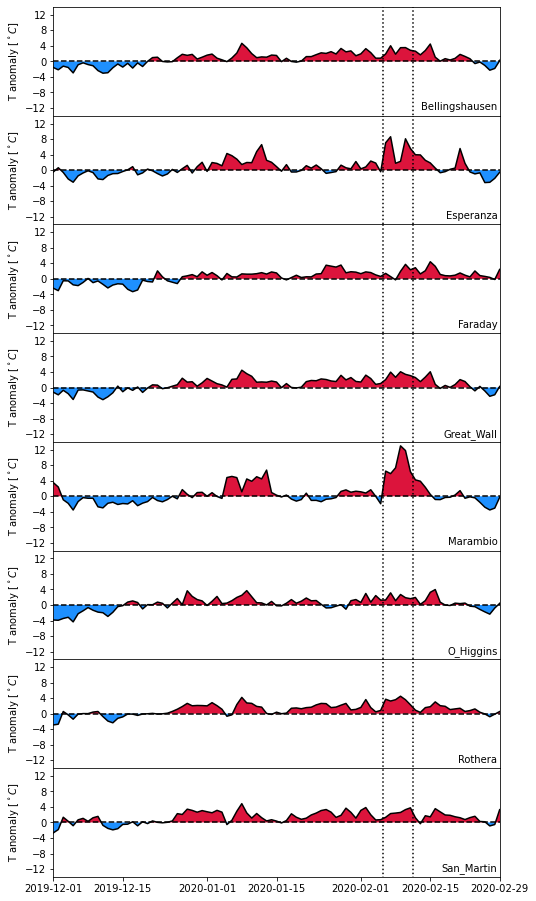

In [26]:
#######################
# Plot sector temperatures with stations
#######################

fig = plt.figure(figsize=(8,16))
gs = fig.add_gridspec(8, 1, hspace=0)
ax1a = fig.add_subplot(gs[0, :])
ax2a = fig.add_subplot(gs[1, :])
ax3a = fig.add_subplot(gs[2, :])
ax4a = fig.add_subplot(gs[3, :])
ax5a = fig.add_subplot(gs[4, :])
ax6a = fig.add_subplot(gs[5, :])
ax7a = fig.add_subplot(gs[6, :])
ax8a = fig.add_subplot(gs[7, :])

stations = ['Bellingshausen', 'Esperanza', 'Faraday', 'Great_Wall', 'Marambio', 'O_Higgins', 'Rothera', 'San_Martin']

#Plot Feb2020 anomaly
for i, ax in enumerate(fig.axes[::]):
    station = stations[i]
    #Load data
    os.chdir('D:\\MEGA\\UBUNTU\\Jupyter\\GRUPOANTARTICO\\Atribution Feb2020')
    filenameAll = station + '.All.temperature.txt'
    #filename00 = station + '.00.temperature.txt'
    #filename06 = station + '.06.temperature.txt'
    #filename12 = station + '.12.temperature.txt'
    #filename18 = station + '.18.temperature.txt'
    dfAll = pd.read_csv(filenameAll, sep=r'\s+', skiprows=1, index_col=0, header=0, na_values='-', names=['YEAR','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    filenameSynop = 'Synop ' + station
    dfSyn = pd.read_csv(filenameSynop, sep='\t', index_col=0, skiprows=1, na_values='-----', usecols=[0,1,2], names=['date', 'hour', 'T'], parse_dates={'datetime': [0, 1]}, dayfirst=True)
    TFebAll_2020 = dfAll[dfAll.index==2020]['Feb'].values[0]
    TFebAll_1979_2019 = dfAll[(dfAll.index>=1950)&(dfAll.index<2020)][['Jan','Feb','Dec']].values
    
    # Plot station temperatures
    #ax = fig.add_subplot(gs)
    ax.plot([datetime.date(2019, 12, 1),datetime.date(2020, 3, 29)], [0,0], 'k--')
    #ax.plot([datetime.date(2019, 12, 1),datetime.date(2020, 2, 29)], [np.mean(TFebAll_1979_2019),np.mean(TFebAll_1979_2019)], '-', color='k', linewidth=0.5)
    ax.plot(dfSyn['T'].resample('D').mean().index, dfSyn['T'].resample('D').mean()-np.nanmean(TFebAll_1979_2019), 'k-')
    ax.set_xlim([datetime.date(2019, 12, 1),datetime.date(2020, 2, 29)])
    ax.fill_between(dfSyn['T'].resample('D').mean().index, dfSyn['T'].resample('D').mean()-np.nanmean(TFebAll_1979_2019), 0, where= dfSyn['T'].resample('D').mean()>= np.nanmean(TFebAll_1979_2019), facecolor='Crimson', interpolate=True)
    ax.fill_between(dfSyn['T'].resample('D').mean().index, dfSyn['T'].resample('D').mean()-np.nanmean(TFebAll_1979_2019), 0, where= dfSyn['T'].resample('D').mean()<= np.nanmean(TFebAll_1979_2019), facecolor='Dodgerblue', interpolate=True)
    ax.annotate(station, xy=(0.995, 0.05), xycoords='axes fraction', ha='right')
    if i < 7:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    
    ax.set_ylim([-np.max(np.abs(dfSyn['T'])-1),np.max(np.abs(dfSyn['T'])+1)])
    ax.set_yticks([-12,-8,-4,0,4,8,12])
    ax.set_ylim([-14,14])
    ax.set_ylabel('T anomaly [$^\circ C$]')
    
ax8a.set_xticks([datetime.date(2019, 12, 1),datetime.date(2019, 12, 15),datetime.date(2020, 1, 1),datetime.date(2020, 1, 15),datetime.date(2020, 2, 1),datetime.date(2020, 2, 15),datetime.date(2020, 2, 29)])
ax8a.set_xticklabels([datetime.date(2019, 12, 1),datetime.date(2019, 12, 15),datetime.date(2020, 1, 1),datetime.date(2020, 1, 15),datetime.date(2020, 2, 1),datetime.date(2020, 2, 15),datetime.date(2020, 2, 29)])

for ax in fig.axes[:]:
    ax.plot([datetime.datetime(2020, 2, 5, 12),datetime.datetime(2020, 2, 5, 12)], [-60,60], 'k:')
    ax.plot([datetime.datetime(2020, 2, 11, 12),datetime.datetime(2020, 2, 11, 12)], [-60,60], 'k:')